In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [24]:
# データの読み込み
data = pd.read_csv('dataframe.csv')
X = data.iloc[:, :-1].values  # 入力データ (スピン配位)
y = data.iloc[:, -1].values   # 教師データ (温度)

In [25]:
# データのサイズを確認
X.shape , y.shape

((25000, 100), (25000,))

In [26]:
y

array([0.01, 0.01, 0.01, ..., 6.  , 6.  , 6.  ])

In [27]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [28]:
# NumPy配列からPyTorchのテンソルに変換
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (25000,) -> (25000, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)    # (6250,) -> (6250, 1)

In [29]:
y_train

tensor([[3.0000],
        [0.5000],
        [2.2500],
        ...,
        [0.0100],
        [3.7500],
        [5.7500]])

正解データはone-hot表現にする必要がある

In [30]:
import torch

# y_trainテンソルを新しいテンソルに変換する関数を定義
def to_one_hot(y_train, num_classes=25):
    # one-hotベクトルの初期化
    one_hot = torch.zeros(len(y_train), num_classes)
    
    # 各要素を25次元のone-hotベクトルに変換
    for i, val in enumerate(y_train):
        index = int((val - 0.01) / 0.24)  # 正しいインデックスの計算
        one_hot[i, index] = 1.0
    
    return one_hot

# y_train,y_testをone-hotベクトルに変換
one_hot_y_train = to_one_hot(y_train, num_classes=25)
one_hot_y_test = to_one_hot(y_test, num_classes=25)

In [31]:
one_hot_y_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [32]:
y_train[12]

tensor([5.5000])

In [33]:
one_hot_y_train[11]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])

In [34]:
# データセットの作成
train_dataset = TensorDataset(X_train, one_hot_y_train)
test_dataset = TensorDataset(X_test, one_hot_y_test)

In [35]:
train_dataset[0]

(tensor([ 1.,  1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
          1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,
         -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
         -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
          1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]))

In [36]:
# DataLoaderの設定（バッチサイズ250）
train_loader = DataLoader(train_dataset, batch_size=250, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=250)

In [37]:
# ニューラルネットワークモデルの定義
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [38]:
# モデルの初期化
input_size = 100
hidden_size = 64
output_size = 25
model = NeuralNetwork(input_size, hidden_size, output_size)

In [39]:
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=25, bias=True)
)


In [40]:
# KLダイバージェンス損失関数の定義
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super(KLDivergenceLoss, self).__init__()

    def forward(self, output, target):
        loss = nn.KLDivLoss(reduction='sum')(torch.log(output), target)
        return loss

In [41]:
# 損失関数と最適化アルゴリズムの設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [43]:
# 学習の実行
num_epochs = 7500
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(targets, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(targets).float())
        optimizer.step()
    running_loss /= len(train_loader)
    running_acc /= len(train_loader)
    train_losses.append(running_loss)
    train_accs.append(running_acc)
    #
    # testidation loop
    #
    test_running_loss = 0.0
    test_running_acc = 0.0
    for test_inputs, test_targets in test_loader:
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_targets)
        test_running_loss += test_loss.item()
        test_pred = torch.argmax(test_outputs, dim=1)
        test_running_acc += torch.mean(test_pred.eq(test_targets).float())
    test_running_loss /= len(test_loader)
    test_running_acc /= len(test_loader)
    test_loss.append(test_running_loss)
    test_accs.append(test_running_acc)
    print("epoch: {}, loss: {}, acc: {}, \
        test loss: {}, test acc: {}".format(epoch, running_loss, running_acc, test_running_loss, test_running_acc))

c:\Users\sugay\Anaconda3\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [42]:
# 学習の実行
num_epochs = 7500
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # モデルを学習モードに設定
    for inputs, targets in train_loader:
        optimizer.zero_grad()       # 勾配を初期化
        outputs = model(inputs)     # フォワードパス
        loss = criterion(outputs, targets)
        loss.backward()            # バックプロパゲーション
        optimizer.step()           # パラメータの更新

    model.eval()   # モデルを評価モードに設定
    with torch.no_grad():
        test_loss = 0.0
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    train_losses.append(loss.item())
    test_losses.append(test_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}],  Test Loss: {test_loss:.4f}')

c:\Users\sugay\Anaconda3\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [1/7500],  Test Loss: 3.1998
Epoch [2/7500],  Test Loss: 3.1977
Epoch [3/7500],  Test Loss: 3.1980
Epoch [4/7500],  Test Loss: 3.1973
Epoch [5/7500],  Test Loss: 3.1984
Epoch [6/7500],  Test Loss: 3.1982
Epoch [7/7500],  Test Loss: 3.1994
Epoch [8/7500],  Test Loss: 3.1978
Epoch [9/7500],  Test Loss: 3.2004
Epoch [10/7500],  Test Loss: 3.1984
Epoch [11/7500],  Test Loss: 3.1991
Epoch [12/7500],  Test Loss: 3.1999
Epoch [13/7500],  Test Loss: 3.2017
Epoch [14/7500],  Test Loss: 3.2001
Epoch [15/7500],  Test Loss: 3.1988
Epoch [16/7500],  Test Loss: 3.2004
Epoch [17/7500],  Test Loss: 3.1999
Epoch [18/7500],  Test Loss: 3.2009
Epoch [19/7500],  Test Loss: 3.1996
Epoch [20/7500],  Test Loss: 3.2000
Epoch [21/7500],  Test Loss: 3.2004
Epoch [22/7500],  Test Loss: 3.1995
Epoch [23/7500],  Test Loss: 3.2016
Epoch [24/7500],  Test Loss: 3.2003
Epoch [25/7500],  Test Loss: 3.2004
Epoch [26/7500],  Test Loss: 3.2004
Epoch [27/7500],  Test Loss: 3.1996
Epoch [28/7500],  Test Loss: 3.2002
E

KeyboardInterrupt: 

Final Test Loss: 48858.8125


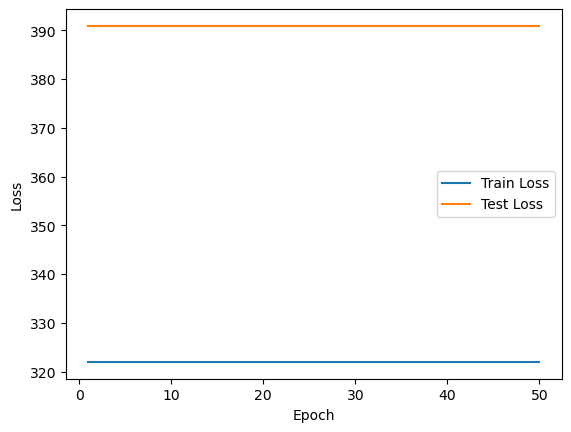

In [ ]:
# モデルの評価
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Final Test Loss: {test_loss:.4f}')

# 損失の可視化
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()